In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
(conjunto_entrenamiento, _), (conjunto_prueba, _) = tf.keras.datasets.mnist.load_data()
conjunto_entrenamiento = conjunto_entrenamiento.astype('float32') / 255.0
conjunto_prueba = conjunto_prueba.astype('float32') / 255.0
conjunto_entrenamiento = np.expand_dims(conjunto_entrenamiento, -1)
conjunto_prueba = np.expand_dims(conjunto_prueba, -1)

forma_entrada = (28, 28, 1)
dim_latente = 2
tamano_lote = 128

entradas = Input(shape=forma_entrada)
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(entradas)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
media_z = Dense(dim_latente)(x)
var_log_z = Dense(dim_latente)(x)

In [ ]:
def muestreo(args):
    media_z, var_log_z = args
    epsilon = tf.random.normal(shape=tf.shape(media_z))
    return media_z + tf.exp(0.5 * var_log_z) * epsilon

z = Lambda(muestreo)([media_z, var_log_z])

entradas_latentes = Input(shape=(dim_latente,))
x = Dense(7 * 7 * 64, activation='relu')(entradas_latentes)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
salidas = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

codificador = Model(entradas, [media_z, var_log_z, z], name='codificador')
decodificador = Model(entradas_latentes, salidas, name='decodificador')
salidas = decodificador(z)
vae = Model(entradas, salidas, name='vae')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.3500 - val_loss: 0.2636
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2638 - val_loss: 0.2628
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2634 - val_loss: 0.2628
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2628 - val_loss: 0.2630
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2632 - val_loss: 0.2626
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2630 - val_loss: 0.2630
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2628 - val_loss: 0.2628
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2632 - val_loss: 0.2629
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2630 - val_loss: 0.2626
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2632 - val_loss: 0.2627
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2628 - val_loss: 0.2627

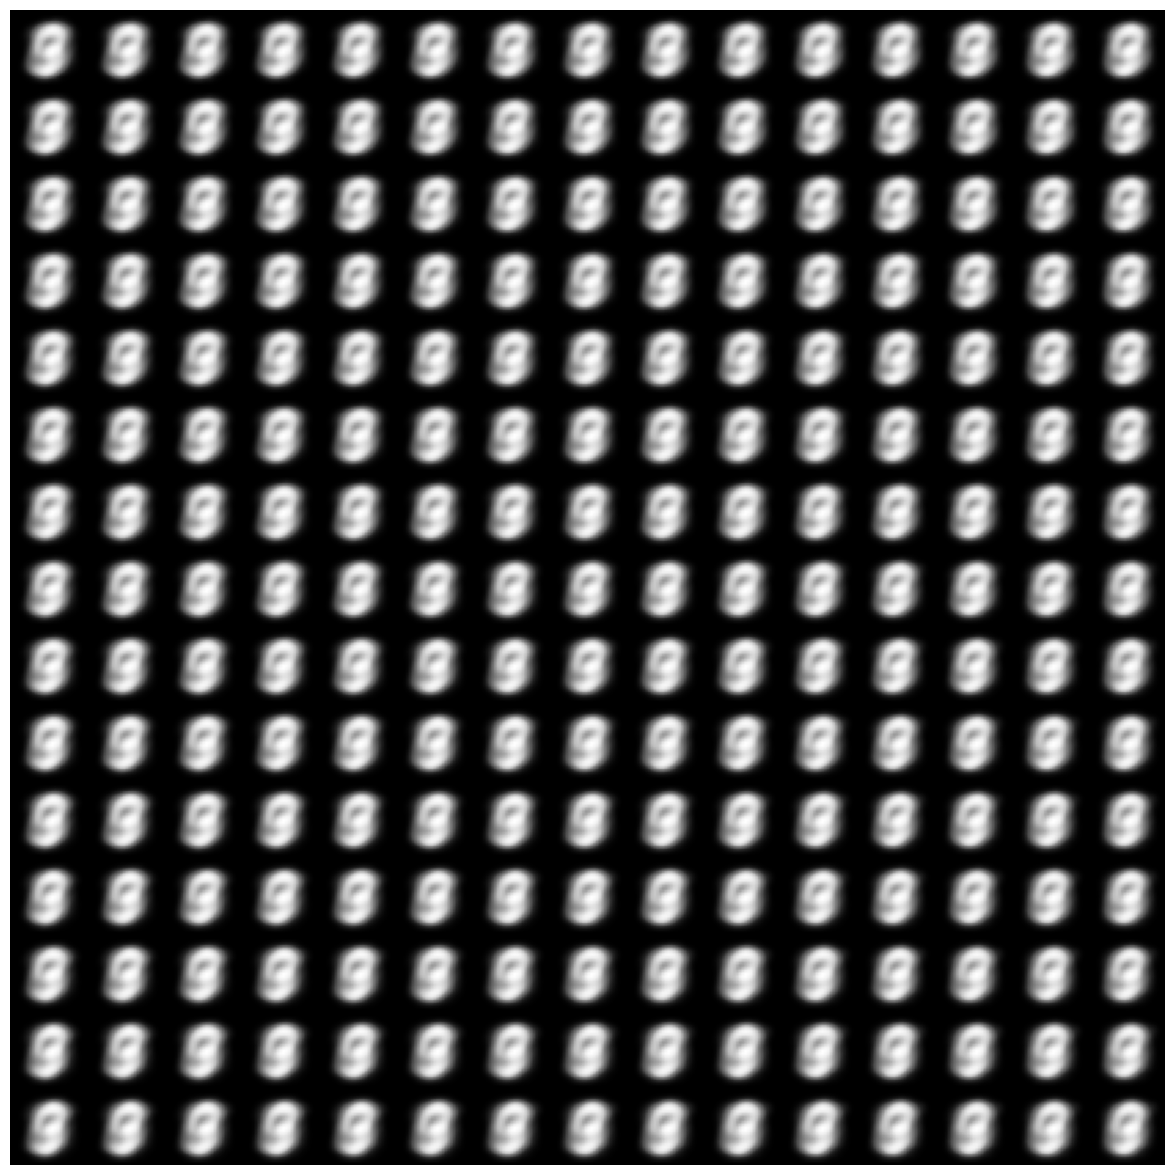

In [ ]:
class CapaPerdidaVAE(Layer):
    def call(self, inputs):
        inputs, outputs, media_z, var_log_z = inputs
        perdida_reconstruccion = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.reshape(inputs, [-1, 28 * 28]), tf.reshape(outputs, [-1, 28 * 28])))
        perdida_kl = 1 + var_log_z - tf.square(media_z) - tf.exp(var_log_z)
        perdida_kl = tf.reduce_mean(tf.reduce_sum(perdida_kl, axis=-1)) * -0.5
        self.add_loss(perdida_reconstruccion + perdida_kl)
        return outputs

vae_salidas = CapaPerdidaVAE()([entradas, salidas, media_z, var_log_z])
vae = Model(entradas, vae_salidas, name='vae')
vae.compile(optimizer='adam')

vae.fit(conjunto_entrenamiento, epochs=30, batch_size=tamano_lote, validation_data=(conjunto_prueba, None))

def graficar_espacio_latente(decodificador, n=15, tamano_figura=15):
    escala = 3.0
    figura = np.zeros((28 * n, 28 * n))
    grid_x = np.linspace(-escala, escala, n)
    grid_y = np.linspace(-escala, escala, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            muestra_z = np.array([[xi, yi]])
            x_decodificado = decodificador.predict(muestra_z)
            digito = x_decodificado[0].reshape(28, 28)
            figura[i * 28: (i + 1) * 28, j * 28 + 1] = digito

    plt.figure(figsize=(tamano_figura, tamano_figura))
    plt.imshow(figura, cmap='Greys_r')
    plt.axis('off')
    plt.show()

graficar_espacio_latente(decodificador)